In [1]:
# coding: utf-8

# # NDAI calculation process
# This process intend to calculate the Vegetation Condition index (VCI) for a specific area. The fomula of the index is:
# NDAI =a*NVAI-(1-a)*NTAI, where a is 0.5
# where the NDAI is Normalized Droguht Anomaly Index.
# This is a WPS process served by PyWPS.
#
# Input:
# bBox:a rectangle box which specifies the processing area.
# date: a date string specifies the date to be calculated. The date format should be "YYYY-MM-DD".
#
# Output:
# file:
# format:
#
# The process internally retrieves NDVI data set from a rasdaman database.
#
# Client side execute script:
# http://localhost/cgi-bin/wpswsgi?service=wps&version=1.0.0&request=execute&identifier=WPS_NDAI_DI_CAL&datainputs=[date=2005-02-06;bbox=50,10,120,60]&responsedocument=image=@asReference=true


# coding: utf-8

# In[ ]:

#from pywps.Process import WPSProcess 
import logging
import os
import sys
import urllib
from lxml import etree
from osgeo import gdal
import numpy as np
import numpy
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
from datetime import datetime, timedelta
import json
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import subprocess as sp
%matplotlib inline

In [2]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)
c = mcolors.ColorConverter().to_rgb

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    
    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

def setMap(rasterBase):

    # Read the data and metadata
    ds = gdal.Open(rasterBase)
    #band = ds.GetRasterBand(20)
    
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #proj = ds.GetProjection()
    
    nan = ds.GetRasterBand(1).GetNoDataValue()
    if nan != None:
        data = np.ma.masked_equal(data,value=nan)
    
    xres = gt[1]
    yres = gt[5]
    
    # get the edge coordinates and add half the resolution 
    # to go to center coordinates
    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
    ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
    ymax = gt[3] - yres * 0.5
    
    x = ds.RasterXSize 
    y = ds.RasterYSize  
    extent = [ gt[0],gt[0]+x*gt[1], gt[3],gt[3]+y*gt[5]]
    #ds = None
    img_extent = (extent[0], extent[1], extent[2], extent[3])
    
    # create a grid of xy coordinates in the original projection
    #xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    
    return extent, img_extent#, xy_source, proj

In [31]:
def MapThatShit(NDAI_BASE,drought_avg_tci_cmap):
    # get array informaiton
    extent, img_extent = setMap(NDAI_BASE)
    ds = gdal.Open(NDAI_BASE)
    #date = ds.GetMetadata()['TIFFTAG_DATETIME']
    date = '20100801'
    array = ds.ReadAsArray()
    #array[ma.getmaskarray(NDAI)] = 0
    #nan = ds.GetRasterBand(1).GetNoDataValue()
    array = ma.masked_equal(array, -9)
    array = np.flipud(array)
    logging.info(extent)

    # set shape of figure
    width = array.shape[0]
    height = array.shape[1]
    base_width = 10.
    base_height = (base_width * height) / width
    print base_width, base_height
    logging.info(base_width, base_height)

    # figure
    fig = plt.figure(figsize=(base_height,base_width)) 
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.set_extent(extent, ccrs.Geodetic())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xlabels_top = False
    # prulletaria on the map
    
    ogr2ogr = r'C:\Program Files\GDAL//ogr2ogr.exe'
    base_geom = r'D:\Data\ChinaShapefile\natural_earth'
    # ocean
    in_file_ocean = base_geom + '\physical//10m_ocean.shp'    
    outfile_ocean = 'ocean.shp'
    # country boudaries
    in_file_bound = base_geom + '\cultural//10m_admin_0_boundary_lines_land.shp' 
    outfile_bound = 'boundaries.shp'
    # costlie
    in_file_coast = base_geom + '\physical//10m_coastline.shp'
    outfile_coast = 'coastline.shp'
    #lakes
    in_file_lakes = base_geom + '\physical//10m_lakes.shp'
    outfile_lakes = 'lakes.shp'
    # run the clip functions
    
    command = [ogr2ogr, '-f', "ESRI Shapefile", outfile_ocean, in_file_ocean,'-clipsrc',
               str(extent[0]),str(extent[3]),str(extent[1]),str(extent[2]), '-overwrite']
    print (sp.list2cmdline(command))
    norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
    norm.communicate()
    
    command = [ogr2ogr, '-f', "ESRI Shapefile", outfile_bound, in_file_bound,'-clipsrc',
               str(extent[0]),str(extent[3]),str(extent[1]),str(extent[2]), '-overwrite']
    print (sp.list2cmdline(command))
    norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
    norm.communicate()    
    
    command = [ogr2ogr, '-f', "ESRI Shapefile", outfile_coast, in_file_coast,'-clipsrc',
               str(extent[0]),str(extent[3]),str(extent[1]),str(extent[2]), '-overwrite']
    print (sp.list2cmdline(command))
    norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
    norm.communicate()    
    
    command = [ogr2ogr, '-f', "ESRI Shapefile", outfile_lakes, in_file_lakes,'-clipsrc',
               str(extent[0]),str(extent[3]),str(extent[1]),str(extent[2]), '-overwrite']
    print (sp.list2cmdline(command))
    norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
    norm.communicate()        

    ax.add_geometries(Reader(outfile_ocean).geometries(), ccrs.PlateCarree(), facecolor='lightblue')
    ax.add_geometries(Reader(outfile_bound).geometries(), ccrs.PlateCarree(), 
                      facecolor='',linestyle=':', linewidth=2)
    ax.add_geometries(Reader(outfile_coast).geometries(), ccrs.PlateCarree(), facecolor='')
    ax.add_geometries(Reader(outfile_lakes).geometries(), ccrs.PlateCarree(), facecolor='lightskyblue')
    
    # ticks of classes
    bounds = [0., 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
    # ticklabels plus colorbar
    ticks = ['0','0.2','0.4','0.6','0.8','1.0','1.4','1.6','>1.8']
    cmap = cmap_discretize(drought_avg_tci_cmap,9)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(array, origin='upper', extent=img_extent,norm=norm, cmap=cmap, 
                   vmin=0, vmax=255, interpolation='nearest')#, transform=ccrs.Mercator())
    title = 'EDI '+date
    plt.title(title, fontsize=22)
    cb = plt.colorbar(im, fraction=0.0476, pad=0.04, ticks=bounds,norm=norm, orientation='horizontal')
    cb.set_label('Evapotranspiration Deficit Index (mm/d)')
    cb.set_ticklabels(ticks)
    
#     spl_arr_str = str(spl_arr)
#     spl_arr_str = spl_arr_str.replace('[','')
#     spl_arr_str = spl_arr_str.replace(']','')
#     spl_arr_str = spl_arr_str.replace(', ','#')
#     spl_arr_str = spl_arr_str.replace('.','.')
    # and save the shit
#    outpath = 'NDAI_'+date+'_'+spl_arr_str+'.png'
    outpath = 'EDI_png.png'
    plt.savefig(outpath, dpi=200, bbox_inches='tight')
    print outpath
    logging.info(outpath)
    #plt.tight_layout()
    plt.show()
    plt.close(fig)
    fig.clf() 
    return outpath

In [29]:
tci_cmap = make_colormap([c('#F29813'), c('#D8DC44'),0.2, c('#D8DC44'), c('#7EC5AD'),0.4,
                          c('#7EC5AD'), c('#5786BE'),0.6, c('#5786BE'), c('#41438D'),0.8,
                          c('#41438D')])

cb_EDI = make_colormap([c('#45B7F5'), c('#70E1E1'),0.125, c('#70E1E1'), c('#B0F9FF'),0.25, 
                         c('#B0F9FF'), c('#5FDF5E'),0.375, c('#5FDF5E'), c('#AAFA65'),0.5, 
                         c('#AAFA65'), c('#FCF38E'),0.625, c('#FCF38E'), c('#FAC55B'),0.75,
                         c('#FAC55B'), c('#E78E62'),0.875, c('#E78E62'), c('#D14A4E'),1,
                         c('#D14A4E')])

In [9]:
full_url = 'http://192.168.1.104/wps/wpsoutputs/map-fd5a09d0-a221-11e5-883c-4437e647de9f.tif'
tif = urllib.urlretrieve(full_url, 'tif_test')

In [ ]:
outpath = MapThatShit('tif_test',cb_NDAI)

In [18]:
EDI = r'D:\Downloads\ZhengChaolei@Mattijn//EDI_WGS84.tif'

10.0 17.4275979557
"C:\Program Files\GDAL//ogr2ogr.exe" -f "ESRI Shapefile" ocean.shp D:\Data\ChinaShapefile\natural_earth\physical//10m_ocean.shp -clipsrc 103.219872976 35.0892206343 127.670431512 49.1190132641 -overwrite
"C:\Program Files\GDAL//ogr2ogr.exe" -f "ESRI Shapefile" boundaries.shp D:\Data\ChinaShapefile\natural_earth\cultural//10m_admin_0_boundary_lines_land.shp -clipsrc 103.219872976 35.0892206343 127.670431512 49.1190132641 -overwrite
"C:\Program Files\GDAL//ogr2ogr.exe" -f "ESRI Shapefile" coastline.shp D:\Data\ChinaShapefile\natural_earth\physical//10m_coastline.shp -clipsrc 103.219872976 35.0892206343 127.670431512 49.1190132641 -overwrite
"C:\Program Files\GDAL//ogr2ogr.exe" -f "ESRI Shapefile" lakes.shp D:\Data\ChinaShapefile\natural_earth\physical//10m_lakes.shp -clipsrc 103.219872976 35.0892206343 127.670431512 49.1190132641 -overwrite
EDI_png.png


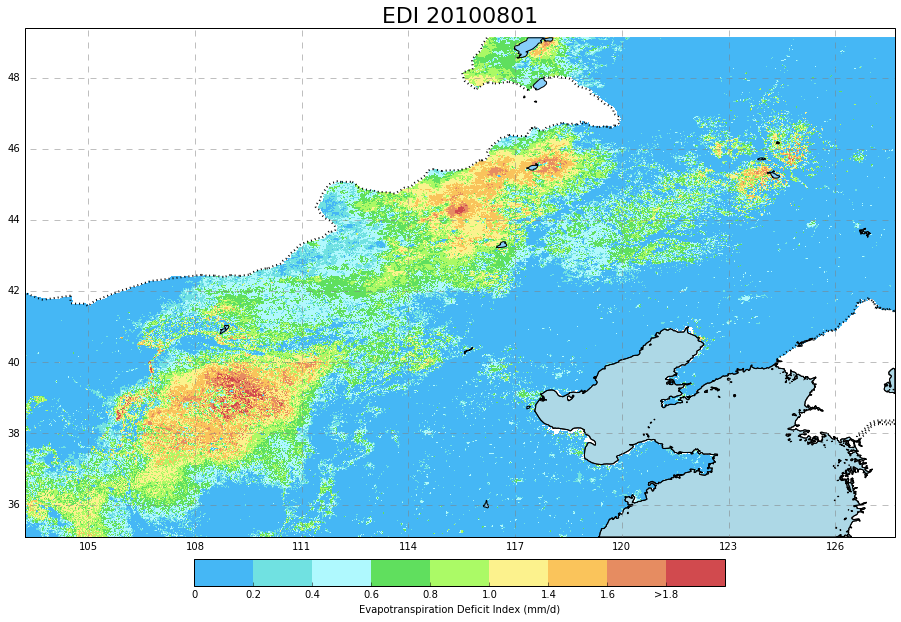

In [32]:
outpath = MapThatShit(EDI,cb_EDI)